In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import numpy as np


import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import kstest, shapiro


In [2]:

def convert_to_dataframe(x):
    return pd.DataFrame(x)


In [3]:
df = pd.read_csv(r'C:\Users\whiter04\OneDrive - Johnson Matthey\00. cspark\ELY\ELY-TimeSeries\Data\master_data_frame.csv')
df_copy = df.copy()
df_copy = df_copy.drop('Unnamed: 0',axis=1) 
df_copy


to_drop = ['temp_anode_inlet_set', 
           'temp_cathode_inlet_set', 
           'pressure_anode_set',
           'pressure_cathode_set', 
           'flow_anode_di_water_supply_set', 
           'flow_cathode_di_water_supply_set', 
          'flow_cathode_di_water_supply', 
           'signal_in_o2_in_h2_sensor']

df_copy = df_copy.drop(to_drop, axis=1)
df_copy


df_copy['seconds'] = (df_copy['time_running_total']/1000).astype(int)
df_copy['minutes'] = (df_copy['seconds']/60).astype(int)

# df_copy['hours'] = (df_copy['minutes']/60).astype(int)
# df_copy['days'] = (df_copy['hours']/24).astype(int)
# df_copy['weeks'] = (df_copy['days']/7).astype(int)
df_copy = df_copy.drop('time_running_total',axis=1)

# df_copy = df_copy.tail(150000)
df_copy

,cell_voltage_001,current,current_density,temp_anode_inlet,temp_anode_outlet,temp_cathode_inlet,temp_cathode_outlet,pressure_anode_inlet,pressure_anode_outlet,pressure_cathode_inlet,pressure_cathode_outlet,flow_anode_di_water_supply,signal_in_resistivity_anode,signal_in_resistivity_cathode,signal_in_h2_in_o2_sensor,seconds,minutes
0,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
1,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
2,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0
3,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,30,0
4,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461237,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,4934550,82242
461238,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,4934550,82242
461239,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,4934580,82243
461240,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,4934580,82243


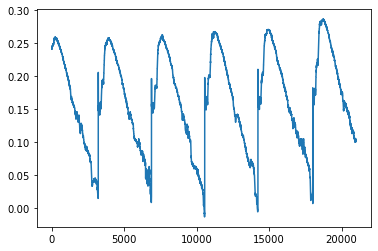

,cell_voltage_001,current,signal_in_h2_in_o2_sensor
minutes,,,
2024-06-27 12:42:00,1.567043,12.500570,0.241426
2024-06-27 12:43:00,1.566948,12.504425,0.240645
2024-06-27 12:44:00,1.566757,12.501270,0.242207
2024-06-27 12:45:00,1.566948,12.498465,0.241426
2024-06-27 12:46:00,1.566852,12.503375,0.240645
...,...,...,...
2024-07-12 02:39:00,1.879218,74.993604,0.101265
2024-07-12 02:40:00,1.879294,75.000614,0.103140
2024-07-12 02:41:00,1.879599,74.996408,0.103140


In [5]:
import matplotlib.pyplot as plt

time_period = 'minutes'

df_time = df_copy.groupby(time_period).mean().reset_index()

downsampled_df = df_time.tail(21000).reset_index()

downsampled_df = downsampled_df[['minutes','cell_voltage_001','current','signal_in_h2_in_o2_sensor']]

downsampled_df[time_period] = pd.to_datetime('2024-05-16 00:00:00') + pd.to_timedelta(downsampled_df[time_period], unit='m')



plt.plot(downsampled_df['signal_in_h2_in_o2_sensor'])

plt.show()

downsampled_df = downsampled_df.set_index('minutes')
downsampled_df

<AxesSubplot:xlabel='minutes'>

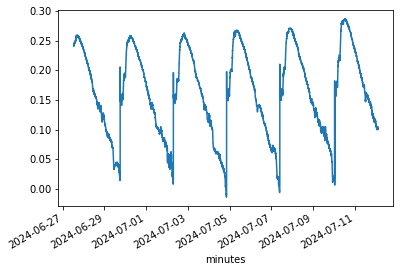

In [6]:

vals = downsampled_df['signal_in_h2_in_o2_sensor']
vals.plot()


(-2.2985641562444474, 0.680400385199823, 4, 20995, {'1%': -4.371682031761406, '5%': -3.8326713191317885, '10%': -3.5534343201834644}, -185981.39795723872)
(-81.87104588119264, 0.0, 3, 20995, {'1%': -4.371682031761406, '5%': -3.8326713191317885, '10%': -3.5534343201834644}, -185968.16589085385)


<AxesSubplot:xlabel='minutes'>

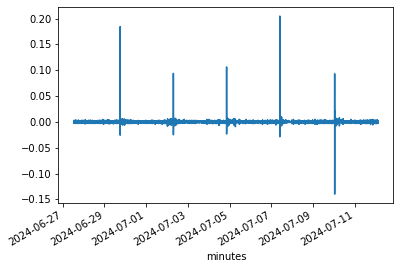

In [7]:

og_data_adf = sm.tsa.stattools.adfuller(downsampled_df['signal_in_h2_in_o2_sensor'], 
                                  regression='ctt', 
                                  autolag='AIC', 
                                  store=False, 
                                  regresults=False)





differenced_data = vals.diff().dropna()


differenced_data_adf = sm.tsa.stattools.adfuller(differenced_data, 
                                  regression='ctt', 
                                  autolag='AIC', 
                                  store=False, 
                                  regresults=False)





print(og_data_adf)

print(differenced_data_adf)

differenced_data.plot()

(-19.542491302396538, 0.0, 46, 20948, {'1%': -4.371683270510881, '5%': -3.8326719503774993, '10%': -3.553434711324142}, -251721.97120997927)


<AxesSubplot:xlabel='minutes'>

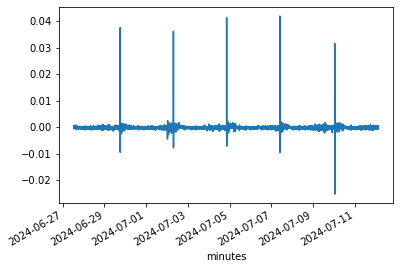

In [8]:
# the presence of large peaks means i shoudl smooth the data to deal with outliers or rapidly changing points 

def moving_average(data, window=10):
    return data.rolling(window=window).mean()


# smoothed
downsampled_df['smoothed_value'] = moving_average(downsampled_df['signal_in_h2_in_o2_sensor'], window=5)


vals_smoothed = downsampled_df['smoothed_value']
vals_smoothed = vals_smoothed.dropna()



# differenced
differenced_data_smoothed = vals_smoothed.diff().dropna()


vals_smoothed_adf = sm.tsa.stattools.adfuller(differenced_data_smoothed, 
                                  regression='ctt', 
                                  autolag='AIC', 
                                  store=False, 
                                  regresults=False)



print(vals_smoothed_adf)

differenced_data_smoothed.plot()

(-14.816575947200157, 1.0857482142166904e-23, 46, 20863, {'1%': -4.371685524978893, '5%': -3.8326730992158007, '10%': -3.5534354231821283}, -292379.1961117088)


<AxesSubplot:xlabel='minutes'>

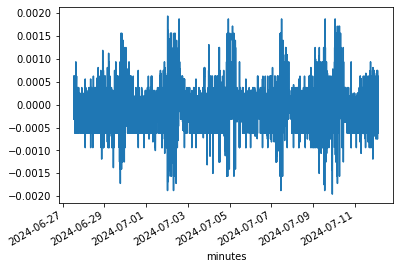

In [9]:
# As the data still contains outliers, i will remove these 


threshold_value = 0.002


differenced_data_smoothed = pd.Series(differenced_data_smoothed)


# removing outliers
differenced_data_smoothed_outliers = differenced_data_smoothed[~((differenced_data_smoothed > threshold_value) | (differenced_data_smoothed < -threshold_value)) ]




differenced_data_smoothed_outliers_adf = sm.tsa.stattools.adfuller(differenced_data_smoothed_outliers, 
                                  regression='ctt', 
                                  autolag='AIC', 
                                  store=False, 
                                  regresults=False)



print(differenced_data_smoothed_outliers_adf)

differenced_data_smoothed_outliers.plot()

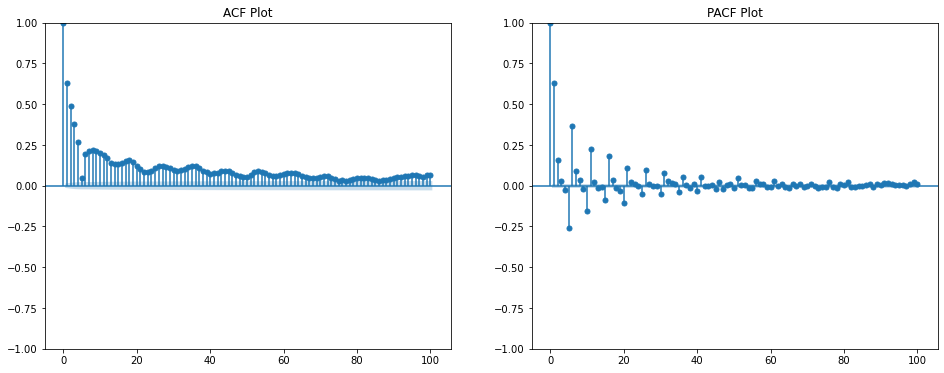

In [10]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot for identifying q
plot_acf(differenced_data_smoothed_outliers, lags=100, ax=axes[0])
axes[0].set_title('ACF Plot')

# PACF plot for identifying p
plot_pacf(differenced_data_smoothed_outliers, lags=100, ax=axes[1])
axes[1].set_title('PACF Plot')

plt.show()

In [11]:
vals_series = pd.Series(differenced_data_smoothed_outliers)

train_size = int(len( vals_smoothed) * 0.8)
train, test = vals_smoothed[:train_size], vals_smoothed[train_size:]




train_size = int(len(vals_series) * 0.8)
train_diff, test_diff = vals_series[:train_size], vals_series[train_size:]


# Apply differencing to make the data stationary
train_diff = train_diff.dropna()
train_diff = train_diff.reset_index(drop=True)


In [12]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 0, 6, 3


# p, d, q = 1, 1, 1
# P, D, Q, s = 1, 1, 0, 3



model = SARIMAX(train_diff, order=(p, d, q ), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

start = len(train_diff)
end = len(train_diff) + len(test) - 1

predictions_diff = model_fit.predict(start=start, end=end, dynamic=False)







C:\Users\whiter04\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.005302926952516304
Root Mean Squared Error: 0.07282119851057317
Root Mean Squared Error percentage: 43.89715904296051%
r2: 0.0636540571978691
AIC: -225519.8102628518
BIC: -225442.56246825866


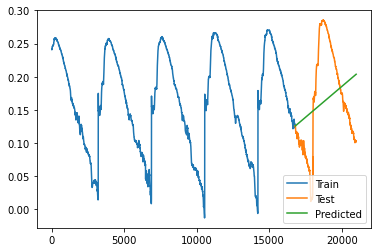

In [13]:
# Evaluate the model
mse = mean_squared_error(test, predictions_diff.cumsum()+train.iloc[-1])
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


rmse_percentage = (rmse/(np.mean(test)))*100
print(f'Root Mean Squared Error percentage: {rmse_percentage}%')


r2 = r2_score(test, predictions_diff.cumsum()+train.iloc[-1])
print(f'r2: {r2}')



# Print AIC and BIC values
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")


# Plot actual vs predicted values
plt.plot(range(len(train)), train, label='Train')
plt.plot(range(len(train), len(train) + len(test)), test, label='Test')
plt.plot(range(len(train), len(train) + len(test)),  predictions_diff.cumsum()+train.iloc[-1], label='Predicted')
plt.legend()
plt.show()


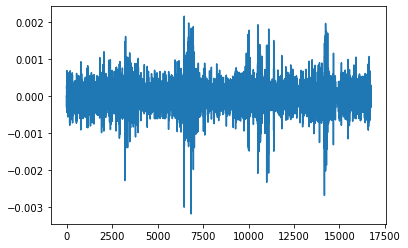

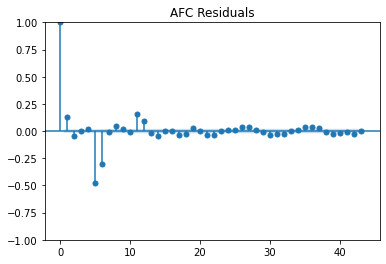

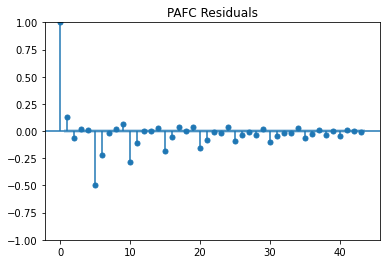

In [16]:
residuals = model_fit.resid
plt.plot(residuals)

plt.show()

plot_acf(residuals)
plt.title('AFC Residuals')
plt.show()



plot_pacf(residuals)
plt.title('PAFC Residuals')
plt.show()

In [22]:
kst = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))

print(f'KS Test: {kst}')

KS Test: KstestResult(statistic=0.0866117959930659, pvalue=1.2544449694146244e-109)
